In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import chart_studio.plotly as py
import plotly.graph_objs as go

In [15]:
def calcular_tamaño_interno_iteraciones(tamaño, maxima_potencia=13):
    """Returns the necessary size for a square grid which is usable in a DS algorithm.
    The Diamond Square algorithm requires a grid of size n x n where n = 2**x + 1, for any 
    integer value of x greater than two. To accomodate a requested map size other than these
    dimensions, we simply create the next largest n x n grid which can entirely contain the
    requested size, and return a subsection of it.
    This method computes that size."""

    if maxima_potencia < 3:
        maxima_potencia = 3

    borde_mas_largo = max(tamaño)

    for potencia in range(1, maxima_potencia + 1):
        d = (2**potencia) + 1
        if borde_mas_largo <= d:
            return (d, d), potencia

    #failsafe: no values in the dimensions array were allowed, so print a warning and return
    # the maximum size.
    d = 2**maxima_potencia + 1
    print("DiamondSquare Warning: Requested size was too large. Grid of size {0} returned""".format(d))
    return (d, d), maxima_potencia

In [8]:
def ejecutar_paso_diamante(array, paso, variabilidad):
    """Does the diamond step for a given iteration.
    During the diamond step, the diagonally adjacent cells are filled:
    Value   None   Value   None   Value  ...
    None   FILLING  None  FILLING  None  ...
 
    Value   None   Value   None   Value  ...
    ...     ...     ...     ...    ...   ...
    So we'll step with increment step_size over BOTH axes
    """
    # calcular las esquinas del diamante
    medio_paso = int(np.floor(paso / 2))
    pasos_x = range(medio_paso, array.shape[0], paso)
    pasos_y = pasos_x[:]

    for i in pasos_x:
        for j in pasos_y:
            if array[i,j] == -1.0:
                array[i,j] = definir_desplazamiento_diamante(array, i, j, medio_paso, variabilidad)

In [9]:
def ejecutar_paso_cuadrado(array, paso, variabilidad):
    """Does the square step for a given iteration.
    During the diamond step, the diagonally adjacent cells are filled:
     Value    FILLING    Value    FILLING   Value   ...
    FILLING   DIAMOND   FILLING   DIAMOND  FILLING  ...
 
     Value    FILLING    Value    FILLING   Value   ...
      ...       ...       ...       ...      ...    ...
    So we'll step with increment step_size over BOTH axes
    """

    # doing this in two steps: the first, where the every other column is skipped
    # and the second, where every other row is skipped. For each, iterations along
    # the half-steps go vertically or horizontally, respectively.

    # set the half-step for the calls to square_displace
    medio_paso = int(np.floor(paso / 2))

    # vertical step
    pasos_verticales_x = range(medio_paso, array.shape[0], paso)
    pasos_verticales_y = range(0, array.shape[1], paso)

    # horizontal step
    pasos_horizontales_x = range(0, array.shape[0], paso)
    pasos_horizontales_y = range(medio_paso, array.shape[1], paso)

    for i in pasos_horizontales_x:
        for j in pasos_horizontales_y:
            array[i,j] = definir_desplazamiento_cuadrado(array, i, j, medio_paso, variabilidad)

    for i in pasos_verticales_x:
        for j in pasos_verticales_y:
            array[i,j] = definir_desplazamiento_cuadrado(array, i, j, medio_paso, variabilidad)

In [22]:
def definir_desplazamiento_diamante(array, i, j, medio_paso, variabilidad):

    # defines the midpoint displacement for the diamond step

    arriba_izq = array[i - medio_paso, j - medio_paso]
    arriba_der = array[i - medio_paso, j + medio_paso]
    abajo_izq = array[i + medio_paso, j - medio_paso]
    abajo_der = array[i + medio_paso, j + medio_paso]

    promedio = (arriba_izq + arriba_der + abajo_izq + abajo_der) / 4.0

    valor_aleatorio = np.random.uniform()

    return (variabilidad * valor_aleatorio) + (1.0 - variabilidad) * promedio

In [61]:
def definir_desplazamiento_cuadrado(array, i, j, medio_paso, variabilidad):
    #Defines the midpoint displacement for the square step
    
    acumulador = 0.0
    dividir_por = 4

    # checkear celda superior
    if i - medio_paso >= 0:
        acumulador += array[i - medio_paso, j]
    else:
        dividir_por -= 1

    # checkear celda inferior
    if i + medio_paso < array.shape[0]:
        acumulador += array[i + medio_paso, j]
    else:
        dividir_por -= 1

    # checkear celda a la izquierda
    if j - medio_paso >= 0:
        acumulador += array[i, j - medio_paso]
    else:
        dividir_por -= 1

    # checkear celda a la derecha
    if j + medio_paso < array.shape[0]:
        acumulador += array[i, j + medio_paso]
    else:
        dividir_por -= 1

    promedio = acumulador / dividir_por

    valor_aleatorio = np.random.uniform()

    return (variabilidad * valor_aleatorio) + (1.0 - variabilidad) * promedio

In [62]:
def generar_terreno(tamaño = (1, 1),
                   altura_min = 0.5,
                   altura_max = 1,
                   variabilidad = 2,
                   semilla = None):
    """Runs a diamond square algorithm and returns an array (or list) with the landscape
        An important difference (possibly) between this, and other implementations of the 
    diamond square algorithm is how I use the roughness parameter. For each "perturbation"
    I pull a random number from a uniform distribution between min_height and max_height.
    I then take the weighted average between that value, and the average value of the 
    "neighbors", whether those be in the diamond or in the square step, as normal. The 
    weights used for the weighted sum are (roughness) and (1-roughness) for the random
    number and the average, respectively, where roughness is a float that always falls 
    between 0 and 1.
        The roughness value used in each iteration is based on the roughness parameter
    passed in, and is computed as follows:
        this_iteration_roughness = roughness**iteration_number
    where the first iteration has iteration_number = 0. The first roughness value 
    actually used (in the very first diamond and square step) is roughness**0 = 1. Thus,
    the values for those first diamond and square step entries will be entirely random.
    This effectively means that I am seeding with A 3x3 grid of random values, rather 
    than with just the four corners.
        As the process continues, the weight placed on the random number draw falls from
    the original value of 1, to roughness**1, to roughness**2, and so on, ultimately 
    approaching 0. This means that the values of new cells will slowly shift from being
    purely random, to pure averages.
    OTHER NOTES:
    Internally, all heights are between 0 and 1, and are rescaled at the end.
    PARAMETERS"""

    # checkeo de parametros
    if variabilidad > 1:
        return 'Error! parametro de variabilidad excedido'
    if variabilidad < 0:
        return 'Error! parametro de variabilidad excedido'

    tamaño_interno, iteraciones = calcular_tamaño_interno_iteraciones(tamaño)
    
    # inicializar el arreglo de floats, los llenamos de "-1"
    array = np.full(tamaño_interno, -1, dtype='float')

    # establecemos la semilla para que al ejecutarlo varias veces nos dé el mismo resultado
    np.random.seed(semilla)

    # paso 1: inicializar las esquinas
    array[0, 0] = np.random.uniform()
    array[tamaño_interno[0] - 1, 0] = np.random.uniform()
    array[0, tamaño_interno[1] - 1] = np.random.uniform()
    array[tamaño_interno[0] - 1, tamaño_interno[1] - 1] = np.random.uniform()

    # repetir los pasos
    for i in range(iteraciones):
        r = np.power(variabilidad, i)

        paso = int(np.floor((tamaño_interno[0] - 1) / np.power(2, i)))

        ejecutar_paso_diamante(array, paso, r)
        ejecutar_paso_cuadrado(array, paso, r)

    # reescalar los valores para satisfacer los limites de altura que se pasaron por parámetro
    array = altura_min + (array * (altura_max - altura_min))

    # recortar el arreglo para satisfacer el tamaño que se pasó por parámetro
    return array[:tamaño[0], :tamaño[1]]

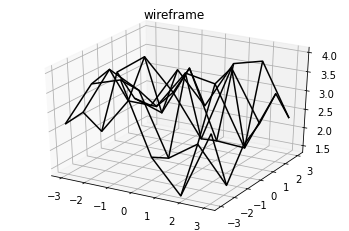

In [63]:
lado = 6
Z = generar_terreno(tamaño=(lado, lado),
               altura_min=1,
               altura_max=5,
               variabilidad=0.8,
                semilla=1)

x = np.linspace(-lado/2, lado/2, lado)
y = np.linspace(-lado/2, lado/2, lado)

X,Y = np.meshgrid(x,y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_title('wireframe')
plt.show()

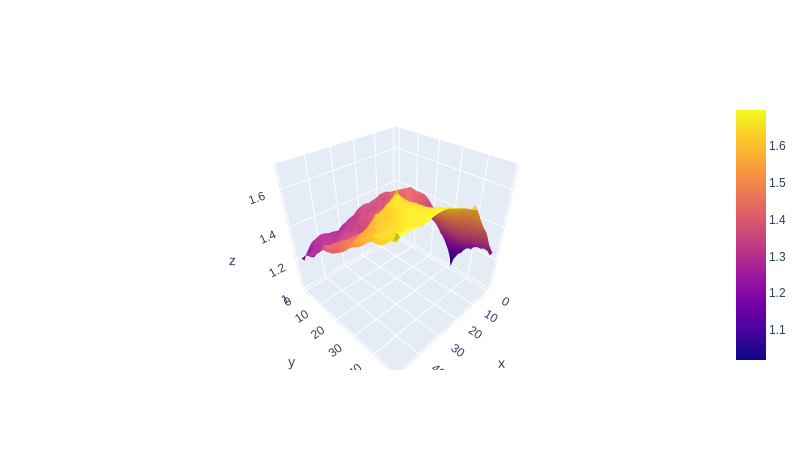

In [64]:
lado = 50
Z = generar_terreno(tamaño=(lado, lado),
               altura_min=1,
               altura_max=2,
               variabilidad=0.3,
               semilla=None)

x = np.linspace(-lado/2, lado/2, lado)
y = np.linspace(-lado/2, lado/2, lado)

X,Y = np.meshgrid(x,y)

fig = go.Figure(data=[go.Surface(z=Z)])
fig.show()

# MATPLOTLIB

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib
import subprocess

In [86]:
N = 50 # Meshsize
fps = 5 # frame per sec
frn = 50 # frame number of the animation

x = np.linspace(-4,4,N+1)
x, y = np.meshgrid(x, x)
zarray = np.zeros((N+1, N+1, frn))

roughnesses = np.linspace(0.7, 0.1, frn)
for i in range(frn):
    zarray[:,:,i] = generar_terreno(tamaño=(N+1, N+1), altura_min=0, altura_max=1, variabilidad=roughnesses[i], semilla=0)

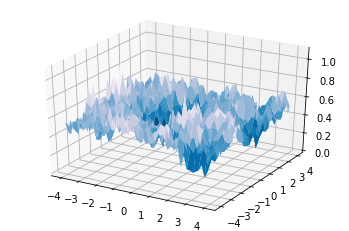

In [87]:
def update_plot(frame_number, zarray, plot):
    global derretimiento
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, zarray[:,:,frame_number] - derretimiento[frame_number], cmap="PuBu_r")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

derretimiento = np.linspace(0, prom, frn+1)
plot = [ax.plot_surface(x, y, zarray[:,:,0], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(0,1.1)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000/fps)

In [88]:
# para mostrar la animación
plt.rcParams['animation.html'] = 'html5'
ani

In [89]:
# para guardar la animación
ani.save('plot_surface_animation_funcanimation.mp4', writer='ffmpeg', fps = fps, dpi = 100)